# Toy problem for TLS solution
We want to solve here the identification problem with TLS in a very simple case: a network with 5 nodes, without any structural contraint.
However, we introduce noise in polar coordinates and we try and use our covariance matrix estimators in order to weight the noise.

In [1]:
import mlflow
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy import sparse
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import sys
sys.path.insert(1, '..')

from src.simulation.noise import add_noise_in_polar_coordinates
from src.models.noise_transformation import naive_noise_covariance, average_true_noise_covariance, exact_noise_covariance
from src.models.error_in_variable import TotalLeastSquares, SparseTotalLeastSquare
from src.models.regression import ComplexLasso
from src.identification.error_metrics import fro_error, error_metrics

In [4]:
mlflow.set_experiment('Toy problem with polar noise')

In [5]:
samples = 300
magnitude_sd = 0.01*1000
phase_sd = 0.01*1000
mlflow_params = {'samples': samples, 'magnitude_sd': magnitude_sd, 'phase_sd': phase_sd}

In [6]:
np.random.seed(11)

y_bus = np.array([
    [1+1j, 0, 0, 0, 0],
    [0, 2+1j, 0, 0, 0],
    [2+1j, 0, 1+1j, 0, 0],
    [0, 0, 0, 2+1j, 0],
    [0, 0, 0, 0, -1-1j],
])
nodes = y_bus.shape[0]

real_voltages = np.random.normal(1, 0.1, (samples, nodes)) + 1j*np.random.normal(0, 0.1, (samples, nodes))
real_currents = real_voltages @ y_bus

voltages, currents = add_noise_in_polar_coordinates(real_currents, real_voltages, magnitude_sd, phase_sd)

voltage_noise = voltages - real_voltages
current_noise = currents - real_currents

# Standard TLS

In [7]:
mlflow.start_run(run_name='TLS')
eiv = TotalLeastSquares()
eiv.fit(voltages, currents)
y_eiv = eiv.fitted_admittance_matrix

[[ 0.01903708-0.19970495j -0.08100274-0.13175838j  0.25101883+0.1039835j
  -0.11693351+0.07113115j  0.25548392+0.44655452j]
 [ 0.05551336+0.00800058j  0.01456106-0.14955359j  0.25785537-0.35204653j
   0.28793525+0.11791239j -0.00854253+0.10528271j]
 [-0.3184018 +0.07964034j -0.34252698-0.14489338j -0.23173304+0.05907818j
  -0.15796239+0.58560572j -0.23678994-0.03591574j]
 [-0.3612798 -0.13603067j  0.08276752-0.11558883j -0.14882934+0.01219479j
  -0.18342104-0.16813231j  0.3002273 +0.36858025j]
 [ 0.15338679+0.46002637j  0.17406047+0.28347222j  0.07135991-0.1495267j
  -0.32396249+0.16558407j  0.03589261+0.10256909j]]


In [8]:
tls_metrics = error_metrics(y_bus, y_eiv)
mlflow.log_params(mlflow_params)
mlflow.log_metrics(tls_metrics.__dict__)
mlflow.end_run()
tls_metrics

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ErrorMetrics(fro_error=6.734577010133884, max_error=2.975967063663329, rrms_error=1.4696051867832336, map_error=1.1910582391677809)

# Standard LASSO

In [9]:
mlflow.start_run(run_name='Lasso')
lasso = ComplexLasso(y_bus, verbose=False, lambdas=np.logspace(-5, 0, 50))
lasso.fit(voltages, currents)
y_lasso = lasso.fitted_admittance_matrix

In [10]:
lasso_metrics = error_metrics(y_bus, y_lasso)
mlflow.log_param('lambda', lasso.best_trial.hyperparameters['lambda'])
mlflow.log_params(mlflow_params)
mlflow.log_metrics(lasso_metrics.__dict__)
mlflow.end_run()
lasso_metrics

ErrorMetrics(fro_error=4.569319494527028, max_error=2.238200910364686, rrms_error=0.9971072599098793, map_error=0.9918908788601946)

In [11]:
lasso.best_trial.hyperparameters

{'lambda': 4.094915062380427e-05}

# L1-regularized TLS

In [12]:
mlflow.start_run(run_name='S-TLS no cov')
tls_lambda = lasso.best_trial.hyperparameters['lambda']
max_iterations = 50
abs_tol = 10e-12
rel_tol = 10e-12
solver = cp.GUROBI
use_l1_penalty = True
use_cov_matrix = False
sparse_eiv = SparseTotalLeastSquare(lambda_value=tls_lambda, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
sparse_eiv.fit(voltages, currents)
y_sparse_eiv = sparse_eiv.fitted_admittance_matrix

  0%|          | 0/50 [00:00<?, ?it/s]/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,
100%|██████████| 50/50 [00:19<00:00,  2.51it/s]


Using license file /Users/jbrouill/gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-17


In [13]:
stls_metrics = error_metrics(y_bus, y_sparse_eiv)
mlflow.log_param('lambda', tls_lambda)
mlflow.log_param('max_iterations', max_iterations)
mlflow.log_param('abs_tol', abs_tol)
mlflow.log_param('rel_tol', rel_tol)
mlflow.log_param('solver', solver)
mlflow.log_param('use_l1_penalty', use_l1_penalty)
mlflow.log_param('use_cov_matrix', use_cov_matrix)
mlflow.log_params(mlflow_params)
mlflow.log_metrics(stls_metrics.__dict__)
y_errors = pd.Series([fro_error(y_bus, i.fitted_parameters) for i in sparse_eiv.iterations])
targets = pd.Series([i.target_function for i in sparse_eiv.iterations])
for i in range(len(y_errors)):
    mlflow.log_metric('fro_error_evo', value=y_errors[i], step=i)
    mlflow.log_metric('opt_cost_evo', value=targets[i], step=i)
mlflow.end_run()
stls_metrics

ErrorMetrics(fro_error=5.784785284959874, max_error=2.525878469618333, rrms_error=1.2623436403521577, map_error=1.0920561141732148)

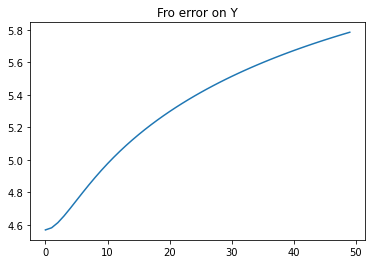

In [14]:
y_errors.plot(title='Fro error on Y');

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


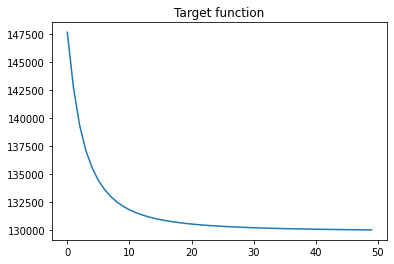

In [15]:
targets.plot(title='Target function');

# L1-regularized TLS with estimated covariance matrix

In [16]:
sigma_voltage = average_true_noise_covariance(voltages, magnitude_sd, phase_sd)
sigma_current = average_true_noise_covariance(currents, magnitude_sd, phase_sd)

inv_sigma_current = sparse.linalg.inv(sigma_current)
inv_sigma_voltage = sparse.linalg.inv(sigma_voltage)

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
mlflow.start_run(run_name='S-TLS')
use_cov_matrix = True
sparse_eiv_cov = SparseTotalLeastSquare(lambda_value=tls_lambda, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
sparse_eiv_cov.fit(voltages, currents, inv_sigma_voltage, inv_sigma_current)
y_sparse_eiv_cov = sparse_eiv_cov.fitted_admittance_matrix

  0%|          | 0/50 [00:00<?, ?it/s]/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,
 84%|████████▍ | 42/50 [00:10<00:02,  3.97it/s]


In [18]:
stls_cov_metrics = error_metrics(y_bus, y_sparse_eiv_cov)
mlflow.log_param('lambda', tls_lambda)
mlflow.log_param('max_iterations', max_iterations)
mlflow.log_param('abs_tol', abs_tol)
mlflow.log_param('rel_tol', rel_tol)
mlflow.log_param('solver', solver)
mlflow.log_param('use_l1_penalty', use_l1_penalty)
mlflow.log_param('use_cov_matrix', use_cov_matrix)
mlflow.log_params(mlflow_params)
mlflow.log_metrics(stls_cov_metrics.__dict__)
y_errors = pd.Series([fro_error(y_bus, i.fitted_parameters) for i in sparse_eiv_cov.iterations])
targets = pd.Series([i.target_function for i in sparse_eiv_cov.iterations])
for i in range(len(y_errors)):
    mlflow.log_metric('fro_error_evo', value=y_errors[i], step=i)
    mlflow.log_metric('opt_cost_evo', value=targets[i], step=i)
mlflow.end_run()
stls_cov_metrics

ErrorMetrics(fro_error=4.548909885038511, max_error=2.252531012738463, rrms_error=0.9926535179867546, map_error=0.9761005146017684)

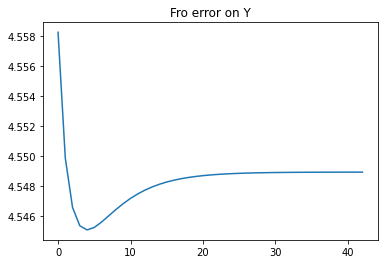

In [19]:
y_errors.plot(title='Fro error on Y');

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


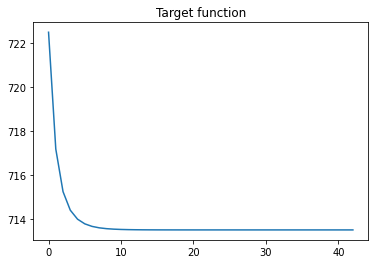

In [20]:
targets.plot(title='Target function');

# L1-regularized TLS with covariance matrix based on actual measurements

In [21]:
real_sigma_voltage = exact_noise_covariance(real_voltages, magnitude_sd, phase_sd)
real_sigma_current = exact_noise_covariance(real_currents, magnitude_sd, phase_sd)

real_inv_sigma_current = sparse.linalg.inv(real_sigma_current)
real_inv_sigma_voltage = sparse.linalg.inv(real_sigma_voltage)

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
mlflow.start_run(run_name='S-TLS on exact covariance matrix')
sparse_eiv_exact_cov = SparseTotalLeastSquare(lambda_value=tls_lambda, abs_tol=abs_tol, rel_tol=rel_tol, solver=solver, max_iterations=max_iterations)
sparse_eiv_exact_cov.fit(voltages, currents, real_inv_sigma_voltage, real_inv_sigma_current)
y_sparse_eiv_exact_cov = sparse_eiv_exact_cov.fitted_admittance_matrix

  0%|          | 0/50 [00:00<?, ?it/s]/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:323: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  return self.solver.solve_via_data(data, warm_start, verbose,
100%|██████████| 50/50 [00:14<00:00,  3.49it/s]


In [23]:
stls_exact_cov_metrics = error_metrics(y_bus, y_sparse_eiv_exact_cov)
mlflow.log_param('lambda', tls_lambda)
mlflow.log_param('max_iterations', max_iterations)
mlflow.log_param('abs_tol', abs_tol)
mlflow.log_param('rel_tol', rel_tol)
mlflow.log_param('solver', solver)
mlflow.log_param('use_l1_penalty', use_l1_penalty)
mlflow.log_param('use_cov_matrix', use_cov_matrix)
mlflow.log_params(mlflow_params)
mlflow.log_metrics(stls_exact_cov_metrics.__dict__)
y_errors = pd.Series([fro_error(y_bus, i.fitted_parameters) for i in sparse_eiv_exact_cov.iterations])
targets = pd.Series([i.target_function for i in sparse_eiv_exact_cov.iterations])
for i in range(len(y_errors)):
    mlflow.log_metric('fro_error_evo', value=y_errors[i], step=i)
    mlflow.log_metric('opt_cost_evo', value=targets[i], step=i)
mlflow.end_run()
stls_exact_cov_metrics

ErrorMetrics(fro_error=5.460012081927514, max_error=2.449321265720717, rrms_error=1.1914723171812507, map_error=1.0548902637874253)

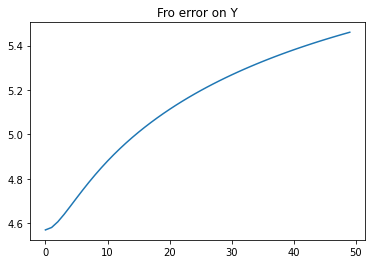

In [24]:
y_errors.plot(title='Fro error on Y');

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


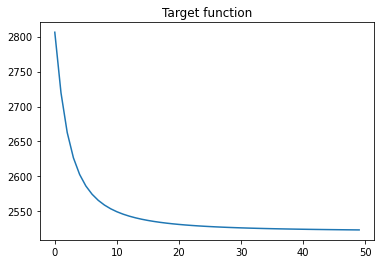

In [25]:
targets.plot(title='Target function');

/Users/jbrouill/PycharmProjects/eiv-grid-id/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


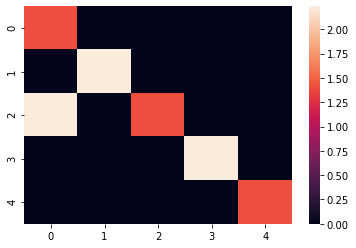

In [26]:
sns.heatmap(np.abs(y_bus));

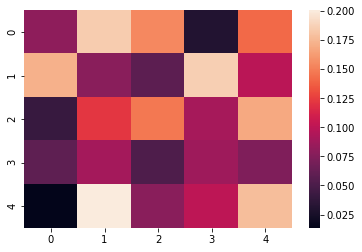

In [27]:
sns.heatmap(np.abs(y_sparse_eiv_cov));